# Simulating the behavior of a single ant foraging for food and lays back pheromone on its way back

Code written using [`jax`](https://jax.readthedocs.io/) with `jit` capability for faster evaluation of functions, loops and gradients

&copy; S Ganga Prasath -- 13 Mar, 2023

In [1]:
#@title Imports & Utils
# Imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# from jax.config import config ; config.update('jax_enable_x64', True)
import jax.numpy as jnp
import jax
from jax import random
from jax import jit
from jax import vmap
from jax import lax

In [2]:
colors = {
    "gray": {
        0: "#f8f9fa",
        1: "#f1f3f5",
        2: "#e9ecef",
        3: "#dee2e6",
        4: "#ced4da",
        5: "#adb5bd",
        6: "#868e96",
        7: "#495057",
        8: "#343a40",
        9: "#212529",
    },
    "red": {
        0: "#fff5f5",
        1: "#ffe3e3",
        2: "#ffc9c9",
        3: "#ffa8a8",
        4: "#ff8787",
        5: "#ff6b6b",
        6: "#fa5252",
        7: "#f03e3e",
        8: "#e03131",
        9: "#c92a2a",
    },
    "pink": {
        0: "#fff0f6",
        1: "#ffdeeb",
        2: "#fcc2d7",
        3: "#faa2c1",
        4: "#f783ac",
        5: "#f06595",
        6: "#e64980",
        7: "#d6336c",
        8: "#c2255c",
        9: "#a61e4d",
    },
    "grape": {
        0: "#f8f0fc",
        1: "#f3d9fa",
        2: "#eebefa",
        3: "#e599f7",
        4: "#da77f2",
        5: "#cc5de8",
        6: "#be4bdb",
        7: "#ae3ec9",
        8: "#9c36b5",
        9: "#862e9c",
    },
    "violet": {
        0: "#f3f0ff",
        1: "#e5dbff",
        2: "#d0bfff",
        3: "#b197fc",
        4: "#9775fa",
        5: "#845ef7",
        6: "#7950f2",
        7: "#7048e8",
        8: "#6741d9",
        9: "#5f3dc4",
    },
    "indigo": {
        0: "#edf2ff",
        1: "#dbe4ff",
        2: "#bac8ff",
        3: "#91a7ff",
        4: "#748ffc",
        5: "#5c7cfa",
        6: "#4c6ef5",
        7: "#4263eb",
        8: "#3b5bdb",
        9: "#364fc7",
    },
    "blue": {
        0: "#e7f5ff",
        1: "#d0ebff",
        2: "#a5d8ff",
        3: "#74c0fc",
        4: "#4dabf7",
        5: "#339af0",
        6: "#228be6",
        7: "#1c7ed6",
        8: "#1971c2",
        9: "#1864ab",
    },
    "cyan": {
        0: "#e3fafc",
        1: "#c5f6fa",
        2: "#99e9f2",
        3: "#66d9e8",
        4: "#3bc9db",
        5: "#22b8cf",
        6: "#15aabf",
        7: "#1098ad",
        8: "#0c8599",
        9: "#0b7285",
    },
    "teal": {
        0: "#e6fcf5",
        1: "#c3fae8",
        2: "#96f2d7",
        3: "#63e6be",
        4: "#38d9a9",
        5: "#20c997",
        6: "#12b886",
        7: "#0ca678",
        8: "#099268",
        9: "#087f5b",
    },
    "green": {
        0: "#ebfbee",
        1: "#d3f9d8",
        2: "#b2f2bb",
        3: "#8ce99a",
        4: "#69db7c",
        5: "#51cf66",
        6: "#40c057",
        7: "#37b24d",
        8: "#2f9e44",
        9: "#2b8a3e",
    },
    "lime": {
        0: "#f4fce3",
        1: "#e9fac8",
        2: "#d8f5a2",
        3: "#c0eb75",
        4: "#a9e34b",
        5: "#94d82d",
        6: "#82c91e",
        7: "#74b816",
        8: "#66a80f",
        9: "#5c940d",
    },
    "yellow": {
        0: "#fff9db",
        1: "#fff3bf",
        2: "#ffec99",
        3: "#ffe066",
        4: "#ffd43b",
        5: "#fcc419",
        6: "#fab005",
        7: "#f59f00",
        8: "#f08c00",
        9: "#e67700",
    },
    "orange": {
        0: "#fff4e6",
        1: "#ffe8cc",
        2: "#ffd8a8",
        3: "#ffc078",
        4: "#ffa94d",
        5: "#ff922b",
        6: "#fd7e14",
        7: "#f76707",
        8: "#e8590c",
        9: "#d9480f",
    },
    "mixed": {
        0: "#880e4f",
        1: "#1a237e",
        2: "#e65100",
        3: "#004d40",
        4: "#c92a2a",
    },
}

In [3]:
class params():
    def __init__(self) -> None:
        super().__init__()
        self.nMax = 100
        self.rInit = jnp.array([0, 0])
        self.thetInit = 0.
        self.dr = 0.1

class ant():
    def __init__(self) -> None:
        super().__init__()
        self.rx = 0.
        self.ry = 0.
        self.thet = 0.
        self.rxFull = self.rx
        self.ryFull = self.ry
        self.thetFull = self.thet
        self.key = random.PRNGKey(30)
        self.subkey = self.key

In [4]:
@jax.jit
def stepFwd(p, agt) -> None:
    agt.key, agt.subkey = random.split(agt.key)
    agt.thet += random.uniform(agt.subkey, minval=-jnp.pi/8, maxval=jnp.pi/8)
    agt.rx += p.dr*jnp.cos(agt.thet)
    agt.ry += p.dr*jnp.sin(agt.thet)
    agt.rxFull = jnp.vstack([agt.rxFull, agt.rx])
    agt.ryFull = jnp.vstack([agt.ryFull, agt.ry])
    agt.thetFull = jnp.vstack([agt.thetFull, agt.thet])

In [6]:
p = params()
ag = ant()
# print(random.uniform(subkey))
# for ind in jnp.arange(p.nMax):
ind = 0
# while ind < p.nMax:
stepFwd(p, ag)
    # ind += 1

TypeError: Cannot interpret value of type <class '__main__.params'> as an abstract array; it does not have a dtype attribute

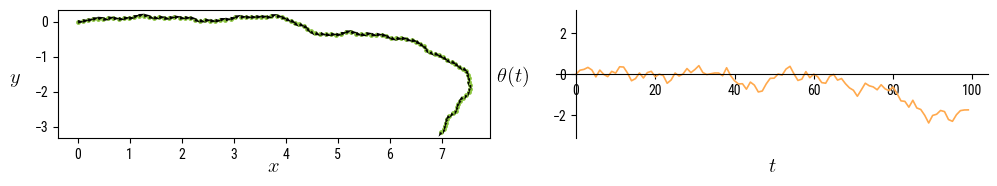

In [27]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc("font", family="Roboto Condensed")
plt.rc("xtick", labelsize="medium")

linewidth = 1.2
linestyle = "-"
label_size = 15
color = '#8dc63f'

fig = plt.figure(figsize=(10, 2))
ax1 = plt.subplot(1, 2, 1)

# ax1.plot(ag.rxFull, ag.ryFull, marker='o', color=colors['orange'][4], zorder=-1, marker_size=2)
ax1.scatter(ag.rxFull, ag.ryFull,
            s=6,
            color=color,
            zorder=-1)
ax1.quiver(ag.rxFull, ag.ryFull,
           jnp.cos(ag.thetFull), jnp.sin(ag.thetFull),
           scale_units='xy', scale=8)
        #    , 'o', color=colors['orange'][4])
ax1.set_xlabel(r'$x$',usetex=True, fontsize=label_size)
ax1.set_ylabel(r'$y$',usetex=True,rotation=0, fontsize=label_size)

ax1.xaxis.set_label_coords(0.5,-0.15)
ax1.yaxis.set_label_coords(-0.1,0.4)


ax2= plt.subplot(1, 2, 2)
t = jnp.arange(p.nMax)
ax2.plot(t, ag.thetFull[:-1],
        color=colors['orange'][4],
        clip_on=False,
        linewidth=linewidth,
        linestyle=linestyle,)
ax2.set_xlabel(r'$t$',usetex=True, fontsize=label_size)
ax2.set_ylabel(r'$\theta(t)$',usetex=True,rotation=0, fontsize=label_size)

ax2.xaxis.set_label_coords(0.5,-0.15)
ax2.yaxis.set_label_coords(-0.1,0.4)

ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["left"].set_position(("data", 0))
ax2.spines["bottom"].set_position(("data", 0))
# ax2.set_xlim([-2*np.pi,2*np.pi])
ax2.set_ylim([-np.pi,np.pi])

plt.tight_layout()
plt.show()